# Mall Customer Segmentation: Quick Data Mining

## Overview
Here, I pose a valauble business question that can be answered using the data at hand. The goal is to illustrate my thought process when tackling business problems using data science. I use the very clean, structured, and small [dataset on kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python) so as emphasize, without cluttering the notebook, a focus on the thought process between key decisions made in the explotory data analysis. Not to say that wrangling and cleaning are not important, but the steps involved can be never-ending. Instead, this notebook shows how I visualize, analyze, and mine raw data for patterns, detailing my reasoning and immediate thoughts leading to each step.

## Outline
0. Problem Statement: Translation from the language of "Business" to "Data Science"
1. The Data: Understanding, + How I would clean
2. Exploratory Data Analysis: General data visualization, log, Standardized/Normalized
3. Data Mining: Segment customers via KNN or K-means... which one? Define a Segment
4. Determine 'In-between' Customers: Are there a significant # customers 'In-Between' two segments? 
6. The Target Customers

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Problem Statement
### Translation of Questions and Goals from *Business* to *Data Science*


**Business Question:** What customers should we (the business) target? 

**Business goal:** Present a list of customers to a marketing team that they will deem "low-hanging fruit", or customers who might be easy to convert to another sale. A marketing team, for example, might task us with finding this out.

**Data Science Question:** Is there a substantial number of customers between any two kinds of spending scores? If so, what features classify or characterize those customers?

**Data Science goal:** Segment customers and identify those that fall in between segments.

**Description:** We need to classify, cluster, or group customers into segments and find those in between segments that can be presented to a marketing team as our best recommendation on who to target. More specifically, I need to identify (if any) a feature (Gender, Age, or Annual Income) or combination of features that characterize a subset of customers that can be pushed into the next highest spending score category. Finding this would allow marketing to better target customers who are most likely to spend more or purchase another item/service, rather than trying to push a whole segment into another spending score. However, this also means that we'll have to come up with meaningful spending score categories which can be tricky for several reasons explained later.

# 1. The Data: How I would clean
Here is the description of our data from the source: 

![Mall Data](https://github.com/justokarell/KaggleMall/blob/master/KaggleDesc.PNG)

This is a very clean, `.xslx` filetype, structured [dataset on kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python). I don't have to do much cleaning but if I needed to, below are my rules of thumb:

**Use Excel if:**
* Fewer than 0.5 million records
* Need to do the job quick and easy
* There's a logical pattern to cleaning the data and it’s easy enough to clean using Excel functions
* The logical pattern data is hard to define, and you need to clean the data manually

**Python or another scripting language:**
* You need to document your process
* You plan on doing the job on a repeat basis
* There is a logical pattern to cleaning the data, but it is hard to implement with Excel functions

In [77]:
# Reading in the file
data = pd.read_excel('C:/Users/jek12/OneDrive/Desktop/data/Mall_Customers.xlsx', sep=",")

# Shape and head of our data
print('\nShape of Data: {} \n'.format(data.shape))
print(data.head(10))


Shape of Data: (200, 5) 

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
5           6  Female   22                  17                      76
6           7  Female   35                  18                       6
7           8  Female   23                  18                      94
8           9    Male   64                  19                       3
9          10  Female   30                  19                      72


In [78]:
# Checking data types
data.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [79]:
# Checking if any null
data.isnull().any().any()

False

In [80]:
# Checking if any NaN
data.isna().any().any()

False

# 2. EDA: Basic Plotting

Here is where I begin visualizing and exploring the raw data as is, checking for things like skewed distributions, patterns across categorical features, etc. Here are a few things I ususally try:

* **Summary Stats**
* **Histograms**
* **Distributions**
* **Scatterplots**
    * "logged" data
    * Standardized data

I'll explain my interpretation of each plot/visualization we proceed.

## Summary Stats

Usually we can get a "feel" for the data just looking at the numbers.

In [84]:
# Creating a quick function to display things side-by-side
import IPython
from IPython.display import display_html
def side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# General summary stats along with count
side_by_side(data.describe(), pd.DataFrame(data['Gender'].describe()))

CustomerID 
 Age 
 Annual Income (k$) 
 Spending Score (1-100) 
 
 
 
 
 count 
 200.000000 
 200.000000 
 200.000000 
 200.000000 
 
 
 mean 
 100.500000 
 38.850000 
 60.560000 
 50.200000 
 
 
 std 
 57.879185 
 13.969007 
 26.264721 
 25.823522 
 
 
 min 
 1.000000 
 18.000000 
 15.000000 
 1.000000 
 
 
 25% 
 50.750000 
 28.750000 
 41.500000 
 34.750000 
 
 
 50% 
 100.500000 
 36.000000 
 61.500000 
 50.000000 
 
 
 75% 
 150.250000 
 49.000000 
 78.000000 
 73.000000 
 
 
 max 
 200.000000 
 70.000000 
 137.000000 
 99.000000 
 
 
 
 
 
 
 Gender 
 
 
 
 
 count 
 200 
 
 
 unique 
 2 
 
 
 top 
 Female 
 
 
 freq 
 112

In [85]:
# I want the summary stats of these columns with respect to gender
cols = data.columns.to_list()[2:]
cols

['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [86]:
# Summary Stats: Left = MaleData, Right = Female Data
mdata = data.loc[data['Gender']=='Male'][cols]
fdata = data.loc[data['Gender']=='Female'][cols]
side_by_side(mdata.describe(),fdata.describe())

,Age,Annual Income (k$),Spending Score (1-100)
count,88.000000,88.000000,88.000000
mean,39.806818,62.227273,48.511364
std,15.514812,26.638373,27.896770
min,18.000000,15.000000,1.000000
25%,27.750000,45.500000,24.500000
50%,37.000000,62.500000,50.000000
75%,50.500000,78.000000,70.000000
max,70.000000,137.000000,97.000000
,Age,Annual Income (k$),Spending Score (1-100)
count,112.000000,112.000000,112.000000


## Distributions: Male vs. Female Feature Distribution and Violin Plots
The data can be categorically divided by gender. Another way to visually compare these features is via violin plots. If you tilt your head sideways, you can see the general shape of the distributions of each feature by gender. 

As we'll see, the general *shape* of the distributions are the same which is a loose indicator that there isn't much of a statistical difference between the distributions.

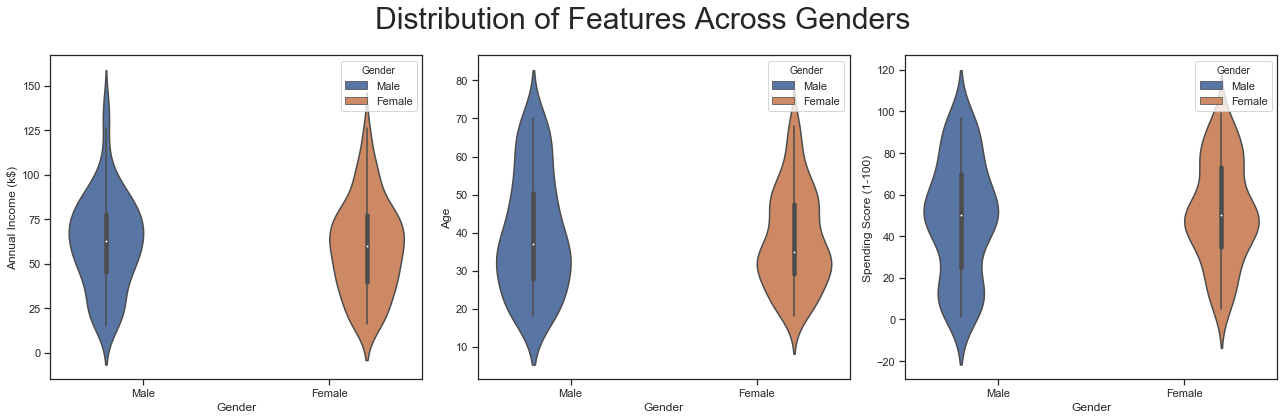

In [87]:
# Creating figure and subplots
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
# ax4 = fig.add_subplot(234)
# ax5 = fig.add_subplot(235)
# ax6 = fig.add_subplot(236)

# Title
plt.suptitle("Distribution of Features Across Genders", fontsize = 30, y=1.05)

# Creating 'Violin' distribution plots of the 
sns.catplot(x="Gender", y="Annual Income (k$)", ax=ax1, kind='violin', data=data, hue='Gender')
sns.catplot(x="Gender", y="Age", ax=ax2, kind="violin", data=data, hue='Gender')
sns.catplot(x="Gender", y="Spending Score (1-100)", ax=ax3, kind="violin", data=data, hue='Gender')
# sns.distplot(data['Annual Income (k$)'], color="m", ax=ax4)
# sns.distplot(data['Age'], color="m", ax=ax5)
# sns.distplot(data['Spending Score (1-100)'], color="m", ax=ax6)
plt.close(2)
plt.close(3)
plt.close(4)


plt.tight_layout()
plt.show()

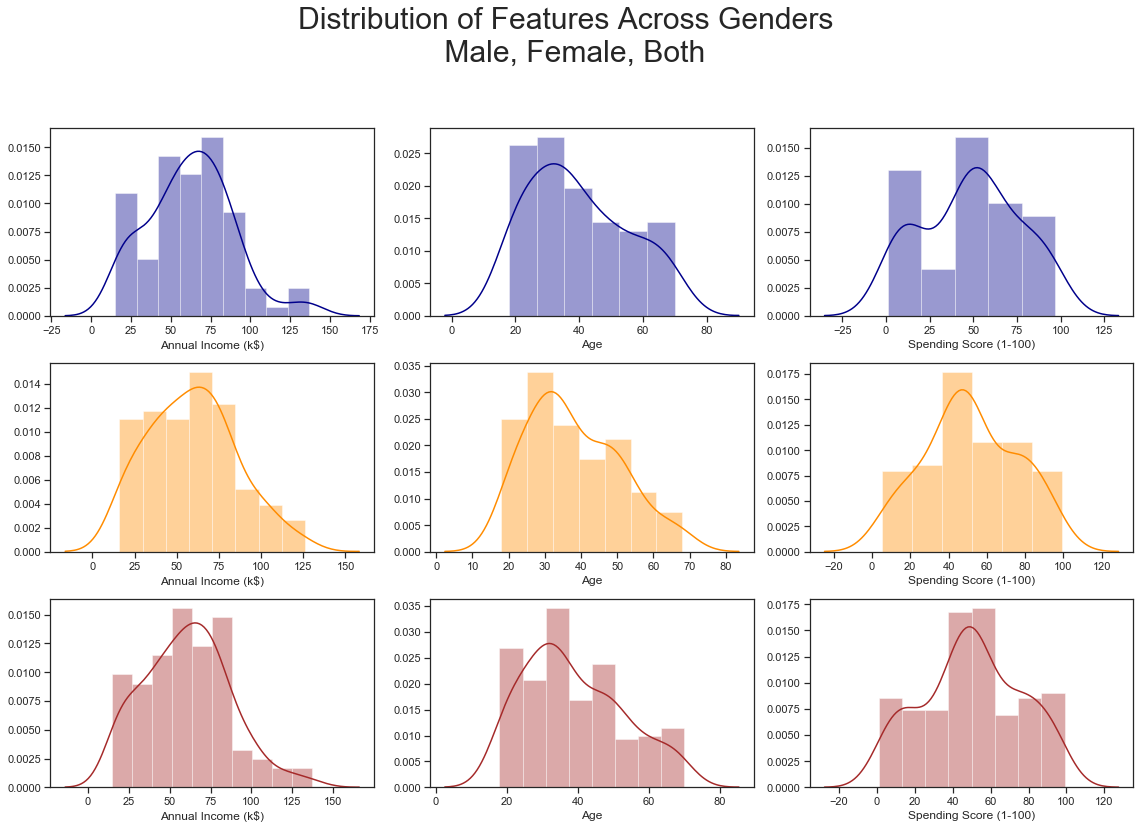

In [11]:
sns.set(style="ticks", color_codes=True)

fig = plt.figure(figsize=(16,10))

# Title
plt.suptitle("Distribution of Features Across Genders \n Male, Female, Both", fontsize = 30, y=1.15)

# Creating subplots
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)
ax7 = fig.add_subplot(337)
ax8 = fig.add_subplot(338)
ax9 = fig.add_subplot(339)

# Adding plots
m_col = 'darkblue'
f_col = 'darkorange'
t_col = 'Brown'
sns.distplot(mdata['Annual Income (k$)'], color=m_col, ax=ax1)
sns.distplot(mdata['Age'], color=m_col, ax=ax2)
sns.distplot(mdata['Spending Score (1-100)'], color=m_col, ax=ax3)
sns.distplot(fdata['Annual Income (k$)'], color=f_col, ax=ax4)
sns.distplot(fdata['Age'], color=f_col, ax=ax5)
sns.distplot(fdata['Spending Score (1-100)'], color=f_col, ax=ax6)
sns.distplot(data['Annual Income (k$)'], color=t_col, ax=ax7)
sns.distplot(data['Age'], color=t_col, ax=ax8)
sns.distplot(data['Spending Score (1-100)'], color=t_col, ax=ax9)
# plt.close(2)
# plt.close(3)
# plt.close(4)

plt.tight_layout()
plt.show()


## Scatterplots
I'm looking for any clear relationships between any of the features here and gender. In the middle plot, there are clear clusters which I'll look at later. For now, I want to finish the EDA exploring any gender bias.

### Basic Scatterplots

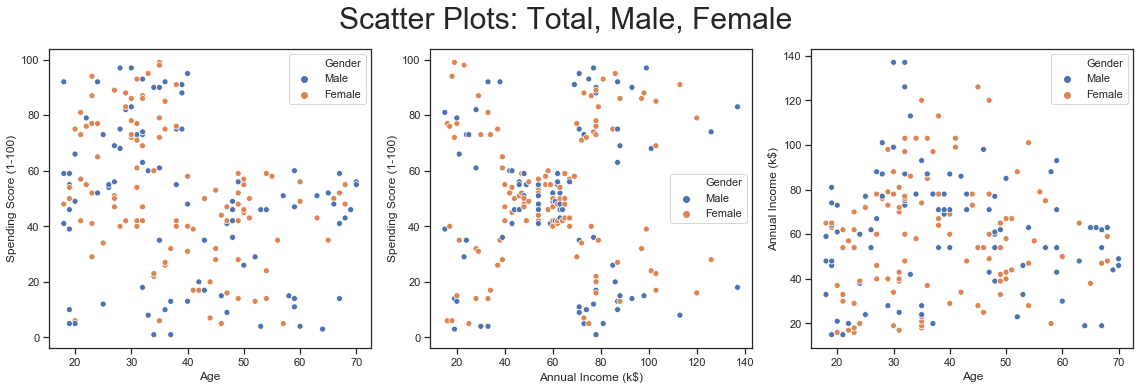

In [91]:

fontsize = 26
fig, ax = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Scatter Plots: Total, Male, Female ', fontsize=30, y= 1.08)


sns.scatterplot(x='Age', y='Spending Score (1-100)', data=data, hue='Gender', ax=ax[0])
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=data, hue='Gender', ax=ax[1])
sns.scatterplot(x='Age', y='Annual Income (k$)', data=data, hue='Gender', ax=ax[2])

plt.tight_layout()
plt.show()

### Clear clusters (segments) in *Annual Income vs. Spending Score*.
However, the influence of gender is not obvious from the plots above so I'll make separate plots.

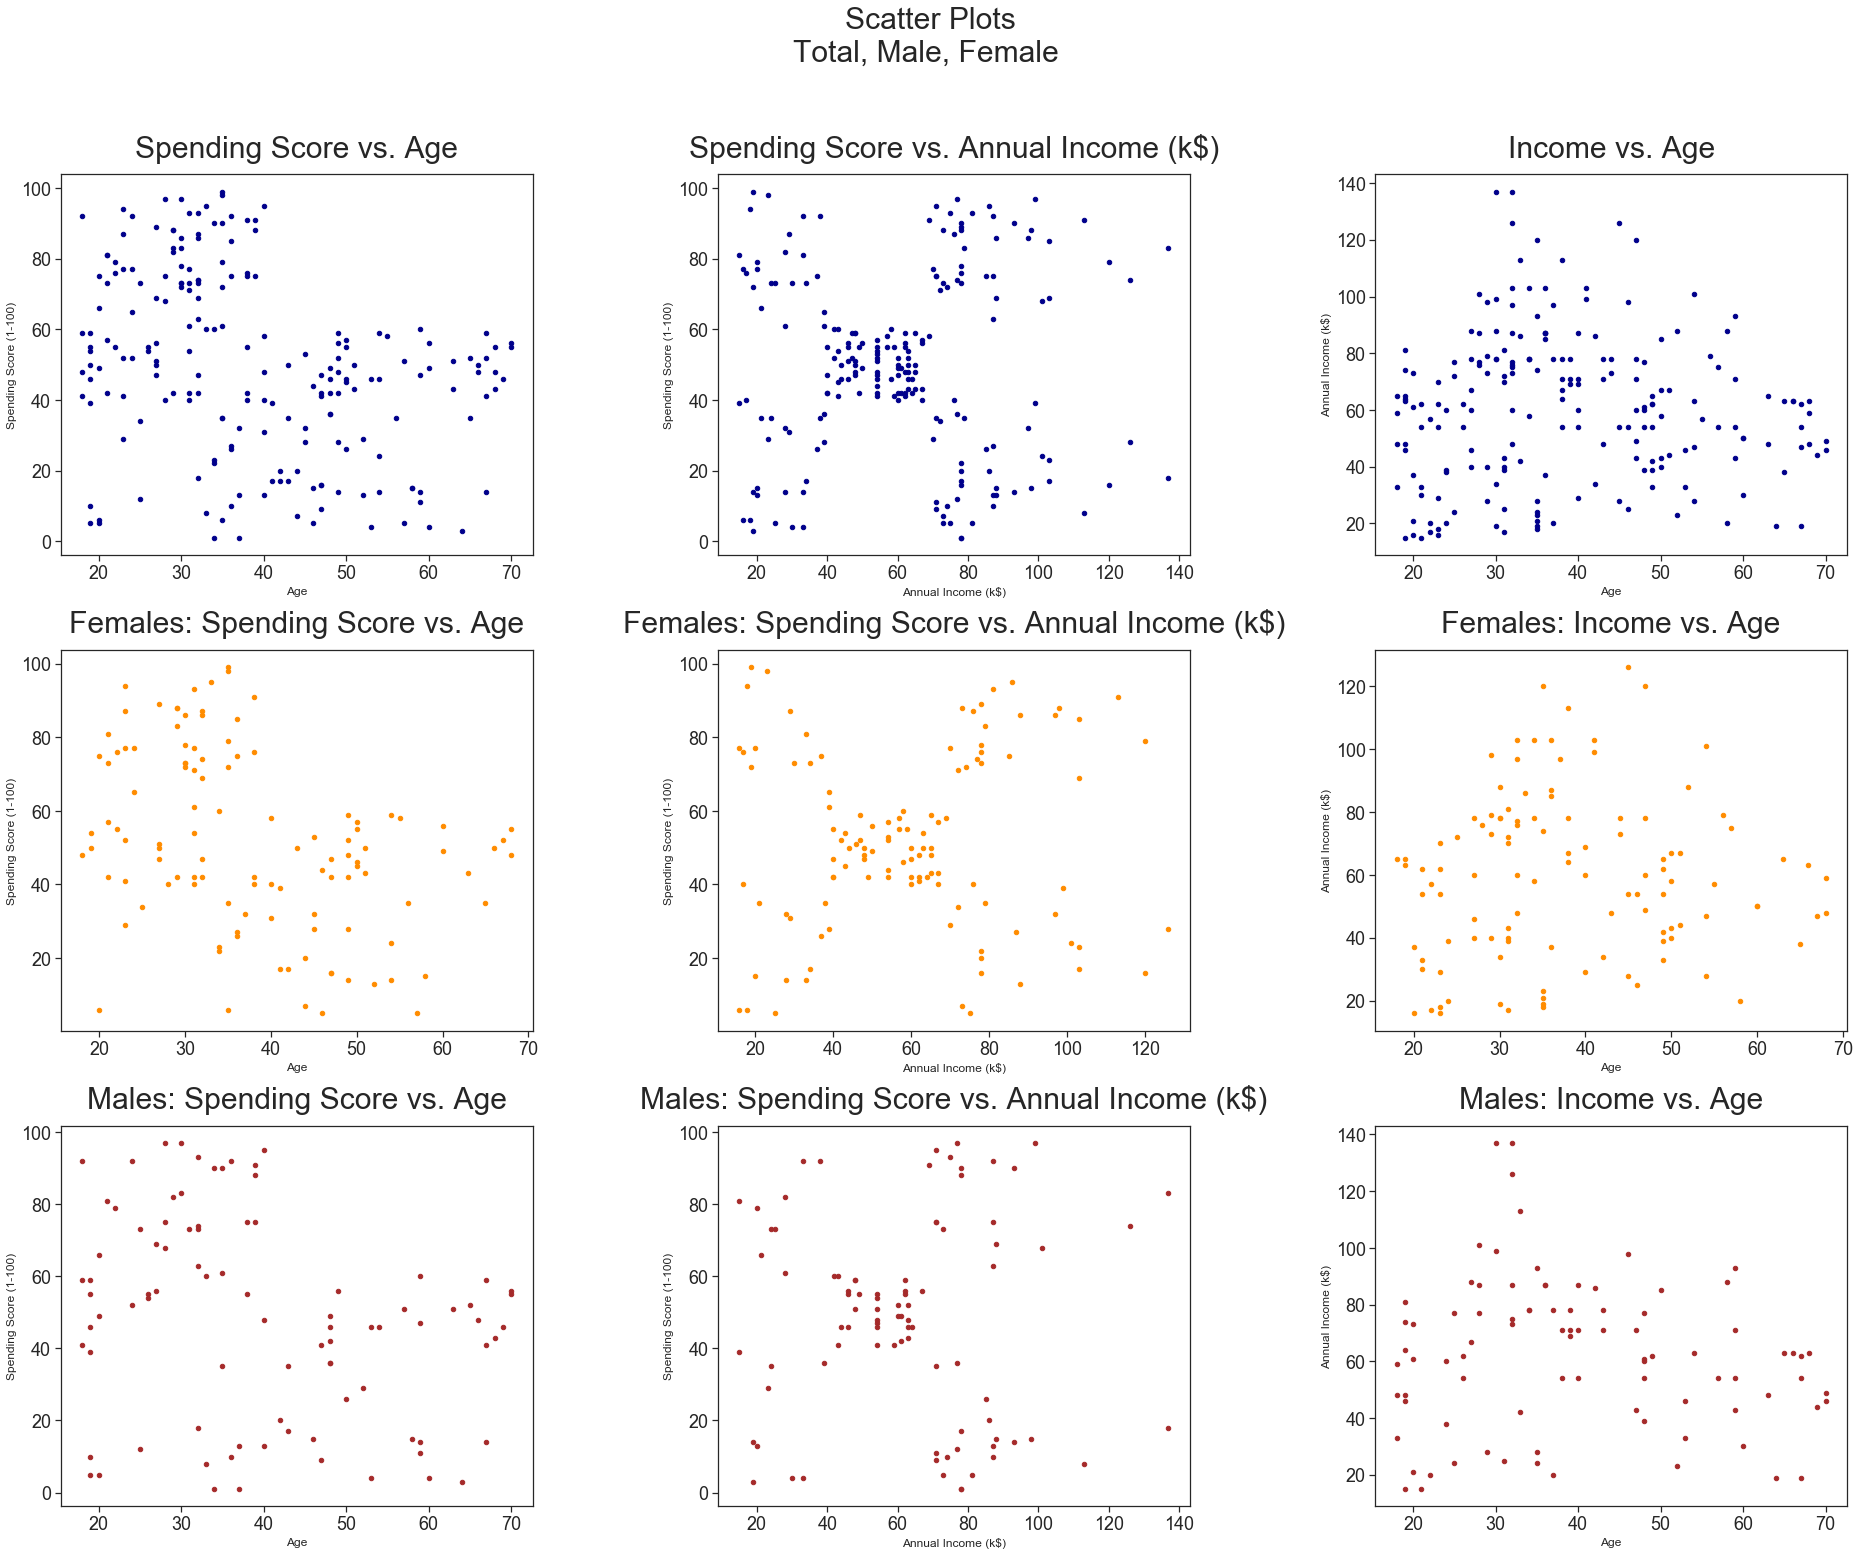

In [92]:

fontsize = 30
fig, ax = plt.subplots(3,3, figsize=(26,20))
fig.suptitle('Scatter Plots\nTotal, Male, Female ', fontsize=30, y= 1.08)

title_space = 1.03
data.plot(x='Age', y='Spending Score (1-100)', c=m_col, ax=ax[0,0], kind='scatter', fontsize=18)
data.plot(x='Annual Income (k$)', y='Spending Score (1-100)', c=m_col, ax=ax[0,1], kind='scatter', fontsize=18)
data.plot(x='Age', y='Annual Income (k$)', c=m_col, ax=ax[0,2], kind='scatter', fontsize=18)
ax[0,0].set_title('Spending Score vs. Age', fontsize=fontsize, y=title_space)
ax[0,1].set_title('Spending Score vs. Annual Income (k$)', fontsize=fontsize, y=title_space)
ax[0,2].set_title('Income vs. Age', fontsize=fontsize, y=title_space)

fdata.plot(x='Age', y='Spending Score (1-100)', c=f_col, ax=ax[1,0], kind='scatter', fontsize=18)
fdata.plot(x='Annual Income (k$)', y='Spending Score (1-100)', c=f_col, ax=ax[1,1], kind='scatter', fontsize=18)
fdata.plot(x='Age', y='Annual Income (k$)', c=f_col, ax=ax[1,2], kind='scatter', fontsize=18)
ax[1,0].set_title('Females: Spending Score vs. Age', fontsize=fontsize, y=title_space)
ax[1,1].set_title('Females: Spending Score vs. Annual Income (k$)', fontsize=fontsize, y=title_space)
ax[1,2].set_title('Females: Income vs. Age', fontsize=fontsize, y=title_space)

mdata.plot(x='Age', y='Spending Score (1-100)', c=t_col, ax=ax[2,0], kind='scatter', fontsize=18)
mdata.plot(x='Annual Income (k$)', y='Spending Score (1-100)', c=t_col, ax=ax[2,1], kind='scatter', fontsize=18)
mdata.plot(x='Age', y='Annual Income (k$)', c=t_col, ax=ax[2,2], kind='scatter', fontsize=18)
ax[2,0].set_title('Males: Spending Score vs. Age', fontsize=fontsize, y=title_space)
ax[2,1].set_title('Males: Spending Score vs. Annual Income (k$)', fontsize=fontsize, y=title_space)
ax[2,2].set_title('Males: Income vs. Age', fontsize=fontsize, y=title_space)

# data.boxplot('Age', ax=ax[1,0])
# data.boxplot('Annual Income (k$)', ax=ax[1,1])
# data.boxplot('Spending Score (1-100)', ax=ax[1,2])

plt.tight_layout()
plt.show()

### "logged" Data

Here we apply a logarithmic transform to our data. In essence, applying the log function allows us to relate data to the scales or magnitudes at which they vary.  

In [94]:
data['logSS']=np.log(data['Spending Score (1-100)'])
data['logAI']=np.log(data['Annual Income (k$)'])
data['logAge']=np.log(data['Age'])
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),logSS,logAI,logAge
0,1,Male,19,15,39,3.663562,2.708050,2.944439
1,2,Male,21,15,81,4.394449,2.708050,3.044522
2,3,Female,20,16,6,1.791759,2.772589,2.995732
3,4,Female,23,16,77,4.343805,2.772589,3.135494
4,5,Female,31,17,40,3.688879,2.833213,3.433987


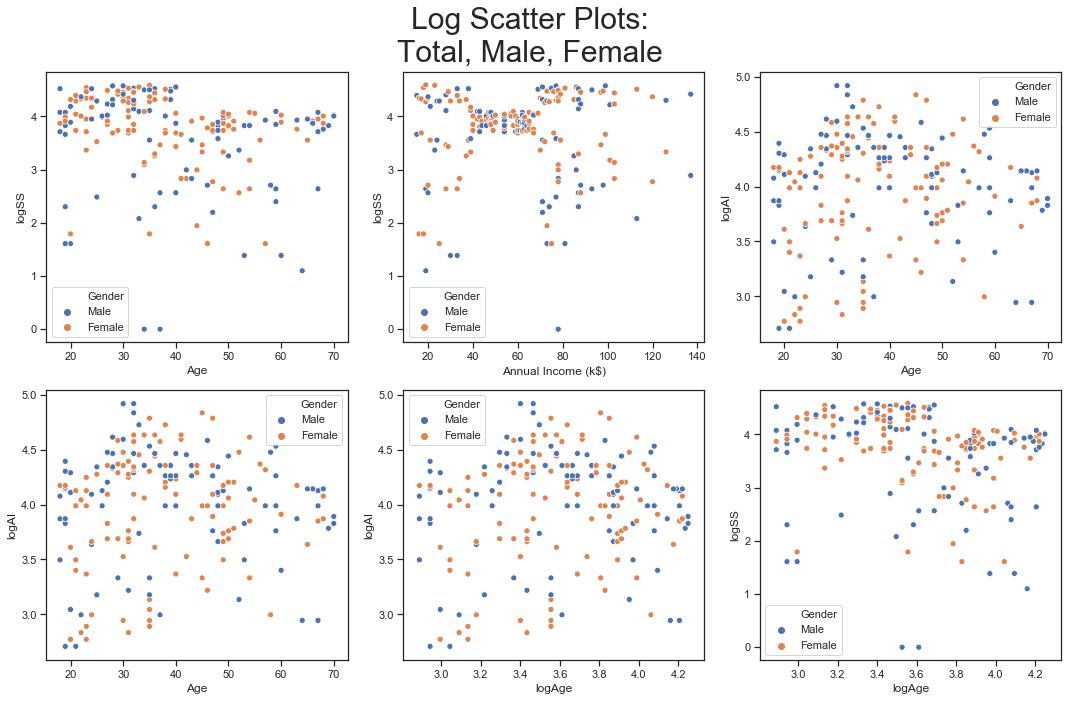

In [95]:
fontsize = 26
fig, ax = plt.subplots(2,3, figsize=(15,9))
fig.suptitle('Log Scatter Plots: \nTotal, Male, Female ', fontsize=30, y= 1.08)


sns.scatterplot(x='Age', y='logSS', data=data, hue='Gender', ax=ax[0,0])
sns.scatterplot(x='Annual Income (k$)', y='logSS', data=data, hue='Gender', ax=ax[0,1])
sns.scatterplot(x='Age', y='logAI', data=data, hue='Gender', ax=ax[0,2])
sns.scatterplot(x='Age', y='logAI', data=data, hue='Gender', ax=ax[1,0])
sns.scatterplot(x='logAge', y='logAI', data=data, hue='Gender', ax=ax[1,1])
sns.scatterplot(x='logAge', y='logSS', data=data, hue='Gender', ax=ax[1,2])

plt.tight_layout()
plt.show()

### Standardized Data

Now we standardize the data. The general interpretation of "standardize" means to center (subtract the mean from each data point) and normalize with respect to standard deviation (divide by the standard deviation). Now, all data represents it's repsective z-score (number of standard deviations away from the mean) with respect to a zero mean.


\begin{align}
\ standardized(x_i) & = (x_i - \mu)/\sigma \\
\end{align}

As we'll see, this doesn't really change the data.

In [96]:
# from sklearn import preprocessing
import sklearn.preprocessing as prep


### Standardized Histograms

In [98]:
# 'normXX' represents a Standardized version of the previous data

data['normAI'] = prep.StandardScaler().fit_transform(np.array(data['Annual Income (k$)']).reshape(-1,1))
data['normSS'] = prep.StandardScaler().fit_transform(np.array(data['Spending Score (1-100)']).reshape(-1,1))
data['normAge'] = prep.StandardScaler().fit_transform(np.array(data['Age']).reshape(-1,1))
data.head()

C:\Users\jek12\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\jek12\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\jek12\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\jek12\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\jek12\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),logSS,logAI,logAge,normAI,normSS,normAge
0,1,Male,19,15,39,3.663562,2.708050,2.944439,-1.738999,-0.434801,-1.424569
1,2,Male,21,15,81,4.394449,2.708050,3.044522,-1.738999,1.195704,-1.281035
2,3,Female,20,16,6,1.791759,2.772589,2.995732,-1.700830,-1.715913,-1.352802
3,4,Female,23,16,77,4.343805,2.772589,3.135494,-1.700830,1.040418,-1.137502
4,5,Female,31,17,40,3.688879,2.833213,3.433987,-1.662660,-0.395980,-0.563369


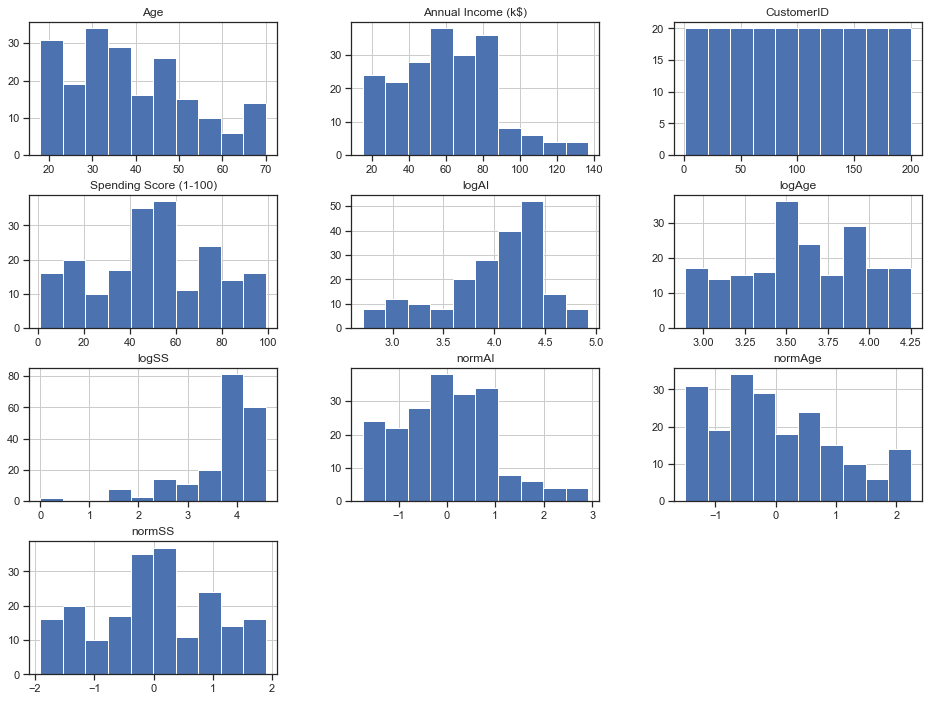

In [99]:
data.hist(figsize=(16,12))
plt.show()

### Standardized Scatterplots

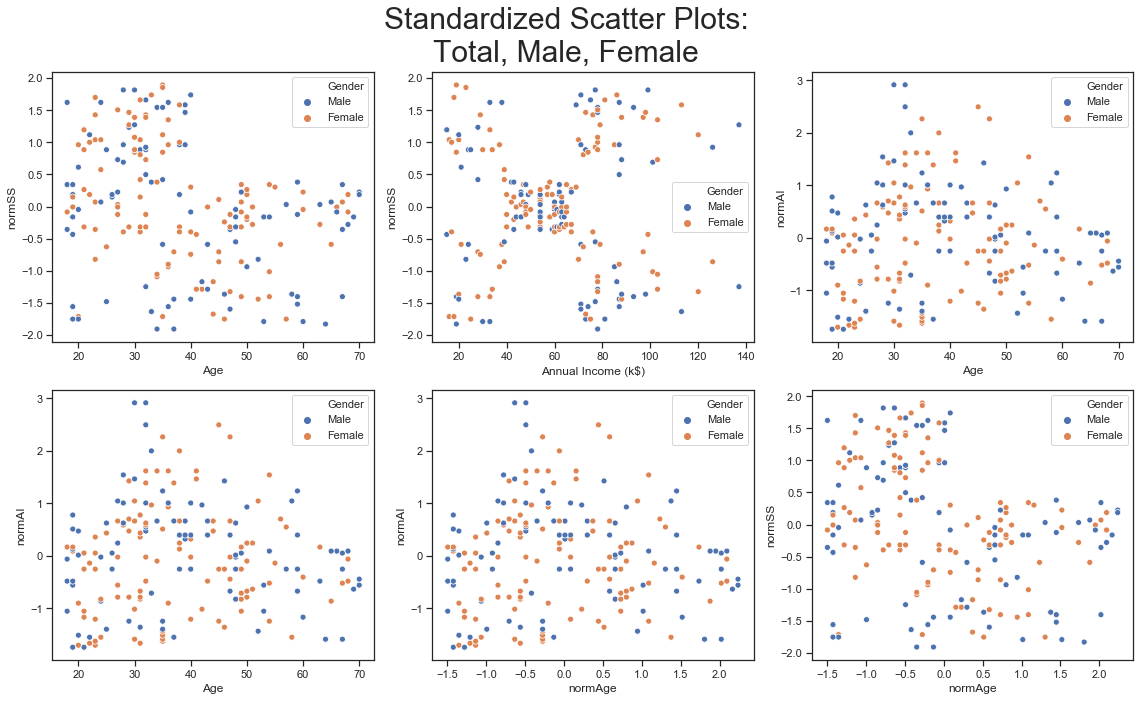

In [48]:
fontsize = 26
fig, ax = plt.subplots(2,3, figsize=(16,9))
fig.suptitle('Standardized Scatter Plots: \nTotal, Male, Female ', fontsize=30, y= 1.08)


sns.scatterplot(x='Age', y='normSS', data=data, hue='Gender', ax=ax[0,0])
sns.scatterplot(x='Annual Income (k$)', y='normSS', data=data, hue='Gender', ax=ax[0,1])
sns.scatterplot(x='Age', y='normAI', data=data, hue='Gender', ax=ax[0,2])
sns.scatterplot(x='Age', y='normAI', data=data, hue='Gender', ax=ax[1,0])
sns.scatterplot(x='normAge', y='normAI', data=data, hue='Gender', ax=ax[1,1])
sns.scatterplot(x='normAge', y='normSS', data=data, hue='Gender', ax=ax[1,2])

plt.tight_layout()
plt.show()

### Standardized Scatterplots by Gender

In [51]:
normcols = ['normSS','normAI','normAge']
mdata = data.loc[data['Gender']=='Male'][normcols]
fdata = data.loc[data['Gender']=='Female'][normcols]
side_by_side(mdata.describe(),fdata.describe())

,normSS,normAI,normAge
count,88.000000,88.000000,88.000000
mean,-0.065555,0.063639,0.068668
std,1.082996,1.016771,1.113447
min,-1.910021,-1.738999,-1.496335
25%,-0.997714,-0.574832,-0.796610
50%,-0.007764,0.074049,-0.132768
75%,0.768667,0.665675,0.836082
max,1.816849,2.917671,2.235532
,normSS,normAI,normAge
count,112.000000,112.000000,112.000000


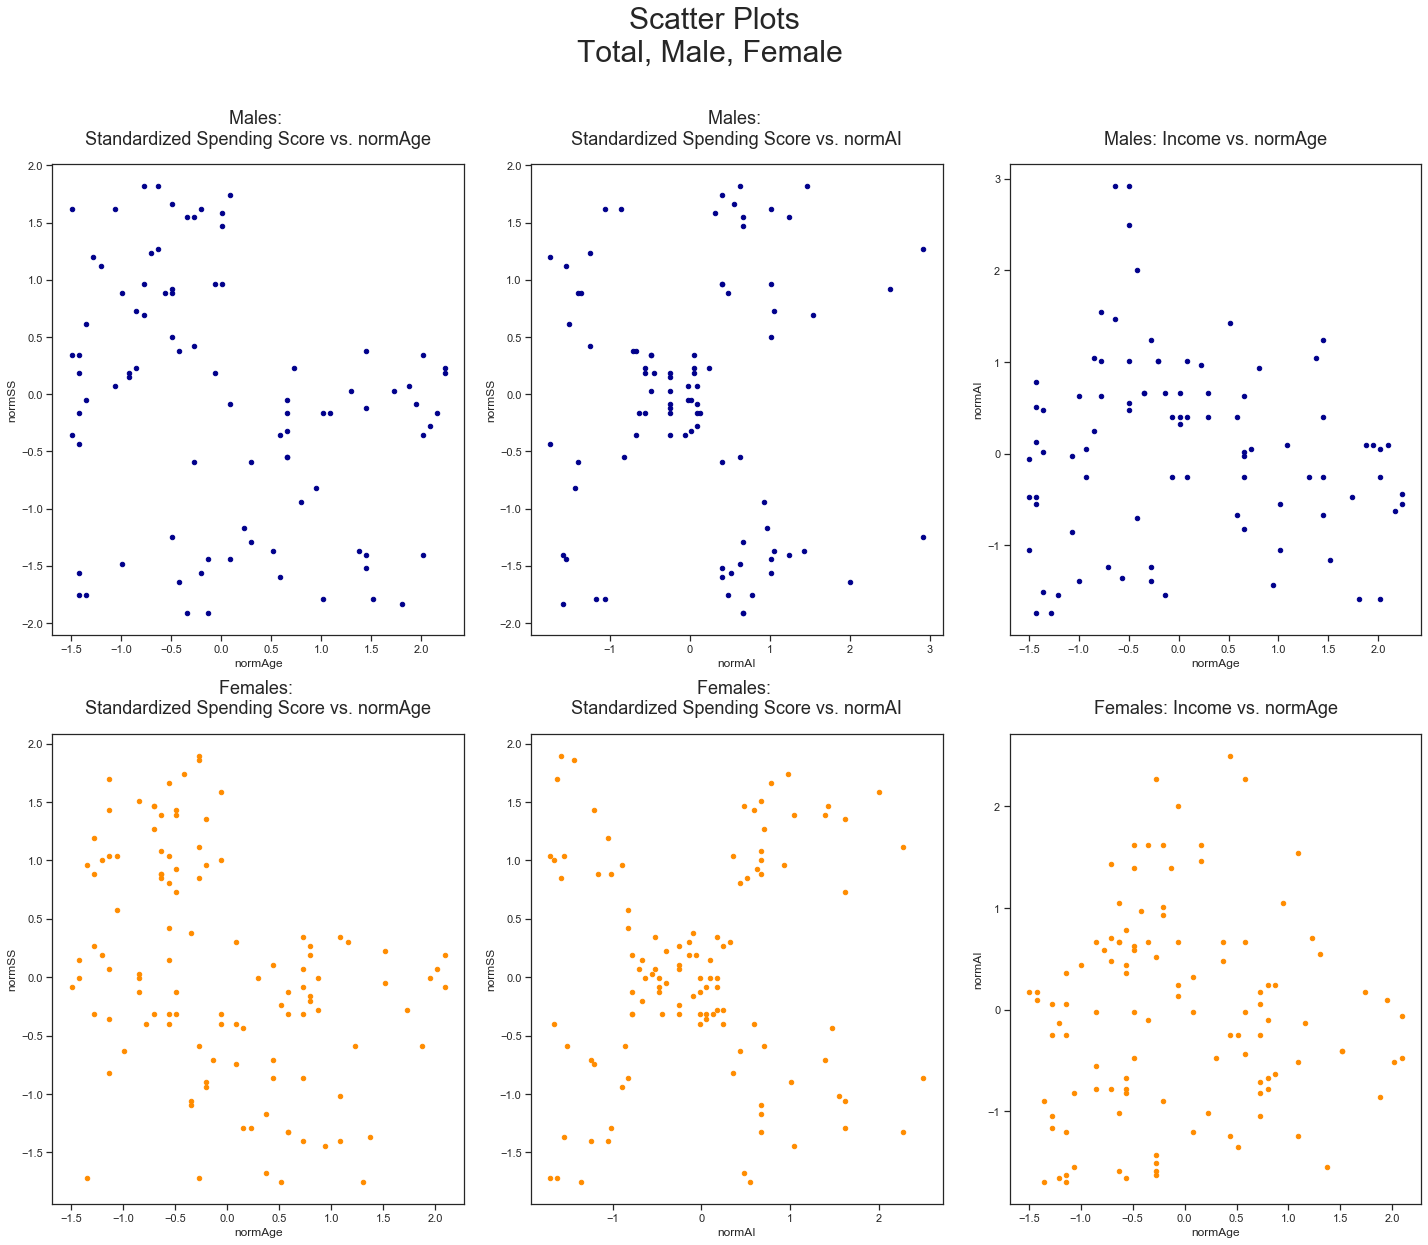

In [75]:

fontsize = 18
fig, ax = plt.subplots(2,3, figsize=(20,16))
fig.suptitle('Scatter Plots\nTotal, Male, Female ', fontsize=30, y= 1.08)

title_space = 1.03

mdata.plot(x='normAge', y='normSS', c=m_col, ax=ax[0,0], kind='scatter', fontsize=11)
mdata.plot(x='normAI', y='normSS', c=m_col, ax=ax[0,1], kind='scatter', fontsize=11)
mdata.plot(x='normAge', y='normAI', c=m_col, ax=ax[0,2], kind='scatter', fontsize=11)
ax[0,0].set_title('Males: \nStandardized Spending Score vs. normAge', fontsize=fontsize, y=title_space)
ax[0,1].set_title('Males: \nStandardized Spending Score vs. normAI', fontsize=fontsize, y=title_space)
ax[0,2].set_title('Males: Income vs. normAge', fontsize=fontsize, y=title_space)

fdata.plot(x='normAge', y='normSS', c=f_col, ax=ax[1,0], kind='scatter', fontsize=11)
fdata.plot(x='normAI', y='normSS', c=f_col, ax=ax[1,1], kind='scatter', fontsize=11)
fdata.plot(x='normAge', y='normAI', c=f_col, ax=ax[1,2], kind='scatter', fontsize=11)
ax[1,0].set_title('Females: \nStandardized Spending Score vs. normAge', fontsize=fontsize, y=title_space)
ax[1,1].set_title('Females: \nStandardized Spending Score vs. normAI', fontsize=fontsize, y=title_space)
ax[1,2].set_title('Females: Income vs. normAge', fontsize=fontsize, y=title_space)

plt.tight_layout()
plt.show()

# 3. Data Mining: Why K-Means
There are clear clusters (potential segments) in when plotting *Annual Income vs. Spending Score*. Why K-Means over KNN or a regression of some sort? Off-the-bat, there are no obvious linear relationships between any of the features of the data. We can check this with a correlation matrix. 

In [69]:

# Correlation matrix shows extremely weak, negative correlation between key features
data[['Age','Annual Income (k$)','Spending Score (1-100)','logSS','logAI','logAge','normAI','normSS','normAge']].corr()

,Age,Annual Income (k$),Spending Score (1-100),logSS,logAI,logAge,normAI,normSS,normAge
Age,1.000000,-0.012398,-0.327227,-0.223182,0.046709,0.982435,-0.012398,-0.327227,1.000000
Annual Income (k$),-0.012398,1.000000,0.009903,-0.018804,0.958069,0.044263,1.000000,0.009903,-0.012398
Spending Score (1-100),-0.327227,0.009903,1.000000,0.894721,0.008193,-0.314254,0.009903,1.000000,-0.327227
logSS,-0.223182,-0.018804,0.894721,1.000000,0.012214,-0.219602,-0.018804,0.894721,-0.223182
logAI,0.046709,0.958069,0.008193,0.012214,1.000000,0.094861,0.958069,0.008193,0.046709
logAge,0.982435,0.044263,-0.314254,-0.219602,0.094861,1.000000,0.044263,-0.314254,0.982435
normAI,-0.012398,1.000000,0.009903,-0.018804,0.958069,0.044263,1.000000,0.009903,-0.012398
normSS,-0.327227,0.009903,1.000000,0.894721,0.008193,-0.314254,0.009903,1.000000,-0.327227
normAge,1.000000,-0.012398,-0.327227,-0.223182,0.046709,0.982435,-0.012398,-0.327227,1.000000


In [70]:
# Male and Female Correlation Matrices show similar behavior across features
side_by_side(mdata.corr(), fdata.corr())

,normSS,normAI,normAge
normSS,1.000000,-0.023684,-0.279628
normAI,-0.023684,1.000000,-0.092978
normAge,-0.279628,-0.092978,1.000000
,normSS,normAI,normAge
normSS,1.000000,0.047542,-0.375439
normAI,0.047542,1.000000,0.059912
normAge,-0.375439,0.059912,1.000000


### Brief Explanation of K-Means

**Description:**
At heart, the K-Means method of clustering is a classification algorithm that solves an optimization problem. It seeks to minimize a quantity called `inertia`, or the "within-cluster" sum of squared criterion:

\begin{align}
\ I & = \sum_{k=1}^n min(||x_j - \mu_j||) \\
\end{align}

In essence, it is a measure of how internally coherent clusters are. 

### What about KNN?

In short, KNN uses previous labels to label and unlabelled data point. K-Means, creates new labels entirely based on features of the data. In the context of classification, the K-nearest neighbor algorithm forms a sort of "majority vote" between the K most similar instances to a given “unseen” observation. That is, if the points around an unclassified point tend to have a certain classification, we'll classify that point with the same "majority" label.
 
Mathematically speaking, the difference between K-Means and KNN can be boiled down to the their objective functions; KNN tends to minimize some distance measure between points in a cluster, whereas K-Means minimizes the aforementioned quantity. Similarity is defined according to a distance metric between two data points. A popular choice is the Euclidean distance given by

\begin{align}
\ d(x,y) & =  \sqrt{\sum_{k=1}^n (x_j - y_j)} \\
\end{align}



### How I use `KMeans()`

I use 5 of the arguments in `KMeans()` out of convention but I'll explain what they mean below and why I use what I use.

**Code:**

``` 
km = KMeans(
    n_clusters = The number of clusters to form as well as the number of centroids to generate, 
    init = ‘random’; choose k observations (rows) at random from data for the initial centroids.,
    n_init = Number of time the k-means algorithm will be run with different centroid seeds. Final results are best output of n_init consecutive runs in terms of inertia.
    max_iter = Maximum number of iterations of the k-means algorithm for a single run before terminating, 
    tol = tolerance = Relative tolerance with regards to inertia to declare convergence., 
)
```

**Reasons**
* `n_clusters = 5` because there are 5 pretty distinct clusters we can see when plotting Spending Score (1-100) vs. Annual Income. 
* `init='random'` because we dont need to worry about time-complexity, which kmeans++ seeks to resolve; it sets a procedure for initializing the cluster centers before proceeding with the standard k-means optimization iterations, which we don't need to do.
* `n_init=10` because our data isn't even close to big or that sparse
* `max_iter=300` this is my go-to starting point before parameter tuning unless it's obvious to try something else
* `tol=1e-04` this is my go-to starting point as well


In [72]:
# Importing what we need
import sklearn
from sklearn.cluster import KMeans

In [101]:
X = np.array(data[['Spending Score (1-100)', 'Annual Income (k$)']])

# There 5 pretty clear clusters, 
km = KMeans(
    n_clusters=5, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04
)

# the predictor
y_km = km.fit_predict(X)


In [102]:
# Inertia = Sum of squared distances of samples to their closest cluster center, or how internally coherent clusters are
# In general, inertia is not a normalized metric: we just know that lower values are better and zero is optimal.
km.inertia_

# This is quite high but we'll see what we can do soon.

44448.45544793371

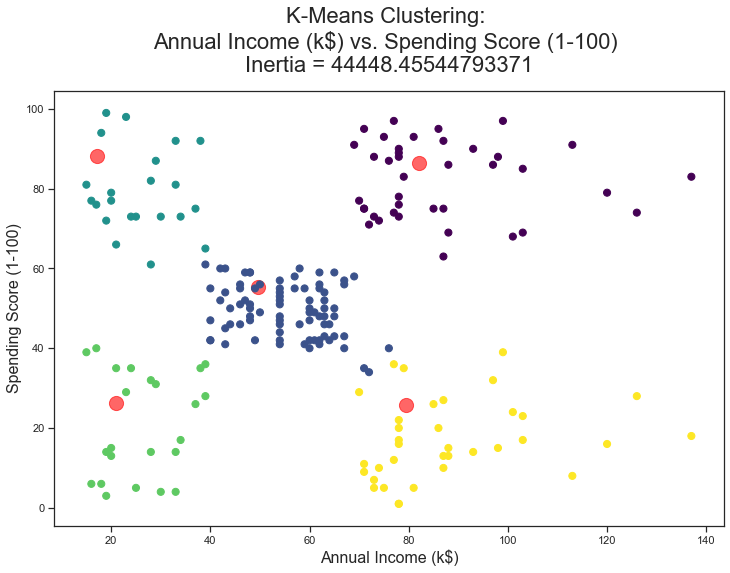

In [103]:
# The red dots are cluster centers

plt.figure(figsize=(12,8))

fontsize = 22
x=np.array(data['Annual Income (k$)'])
y=np.array(data['Spending Score (1-100)'])
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.6)
# plt.scatter(x, y, c='c')
plt.scatter(x, y, c=y_km, s=50, cmap='viridis')
plt.title("K-Means Clustering: \nAnnual Income (k$) vs. Spending Score (1-100) \nInertia = {}".format(km.inertia_), 
          fontsize=fontsize, y=1.03)
plt.xlabel("Annual Income (k$)", fontsize=16)
plt.ylabel("Spending Score (1-100)", fontsize=16)
plt.show()

# 4. A Little Parameter Tuning: Can we lower inertia?
Being quite honest, I doubt we will be able to lower inertia primarily due to the lack of data as well as how clearly defined the clusters are already. Consequently, it's hard to imagine how one would train this model so as to do formal Machine Learning. However, there's no harm in playing around with different hyperparameters a bit to see if anything happens. I tried varying 1 parameter, and nothing happened. Here, I'll vary 2 parameters to show that nothing changes inertia.

Note: I vary parameters simultaneously, however -- given more time -- it may also be worth it to vary parameters individually as other others change; i.e. hold one constant, vary others, and incrementally change the first parameter to see if any differences arise.

In [100]:
tols = np.array([1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 1e-07])
n_inits = np.array([1, 5, 10, 20, 50, 100, 200])
max_iters = np.array([10, 50, 100, 300, 500, 700, 1000])

X = np.array(data[['Spending Score (1-100)', 'Annual Income (k$)']])

# There 5 pretty clear clusters, 
km = KMeans(
    n_clusters=5, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

# the predictor
y_km = km.fit_predict(X)


In [101]:
inertias = []
for a in range(len(tols)):
    tol = tols[a]
    n_init = n_inits[a]
    max_iter = max_iters[a]
    km = KMeans(
        n_clusters=5, init='random',
        n_init=n_init, max_iter=max_iter, 
        tol=tol, random_state=0
    )

    # the predictor
    y_km = km.fit_predict(X)
    
    np.array(inertias.append(km.inertia_))

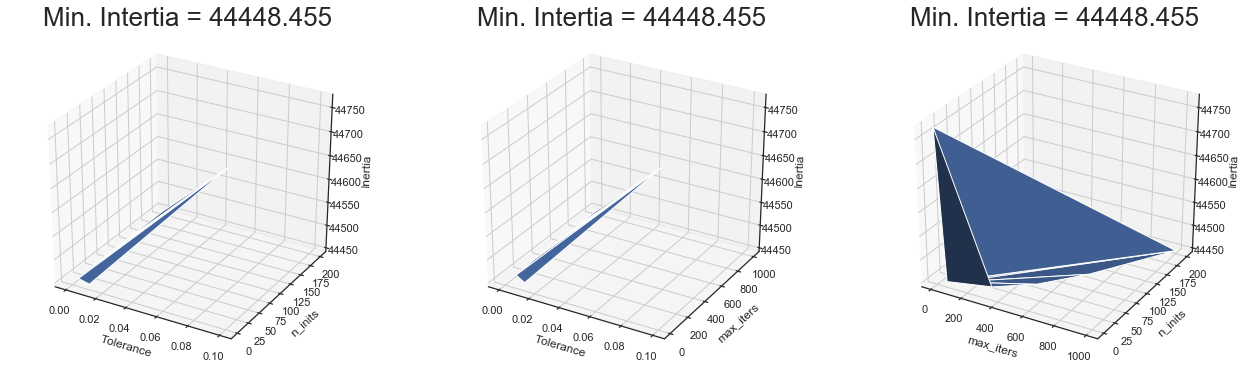

In [102]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d.axes3d import get_test_data

fontsize = 26
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(22,6))#plt.figaspect(0.5))

ax = fig.add_subplot(1, 3, 1, projection='3d')


X = tols
Y = n_inits
Z = np.array(inertias)
ax.set_xlabel('Tolerance')
ax.set_ylabel('n_inits')
ax.set_zlabel('Inertia')
ax.set_title("Min. Intertia = {}".format(round(min(Z), 3)), fontsize = fontsize, y=1.09)
ax.plot_trisurf(X, Y, Z)


ax = fig.add_subplot(1, 3, 2, projection='3d')
X = tols
Y = max_iters
Z = np.array(inertias)
ax.set_xlabel('Tolerance')
ax.set_ylabel('max_iters')
ax.set_zlabel('Inertia')
ax.set_title("Min. Intertia = {}".format(round(min(Z), 3)), fontsize = fontsize, y=1.09)
ax.plot_trisurf(X, Y, Z)


ax = fig.add_subplot(1, 3, 3, projection='3d')
X = max_iters
Y = n_inits
Z = np.array(inertias)
ax.set_xlabel('max_iters')
ax.set_ylabel('n_inits')
ax.set_zlabel('Inertia')
ax.set_title("Min. Intertia = {}".format(round(min(Z), 3)), fontsize = fontsize, y=1.09)
ax.plot_trisurf(X, Y, Z)


plt.show()

# 5. Segmenting and Targetting

Recall that we just found some pretty clear clusters in our previous plot. We're going to take these as our segments. Our now question becomes: Who, within these segments, do we target? 

My best guess is to target the customers just above the Spending Score Quartiles, or at the top of their segment in terms of the Segments.


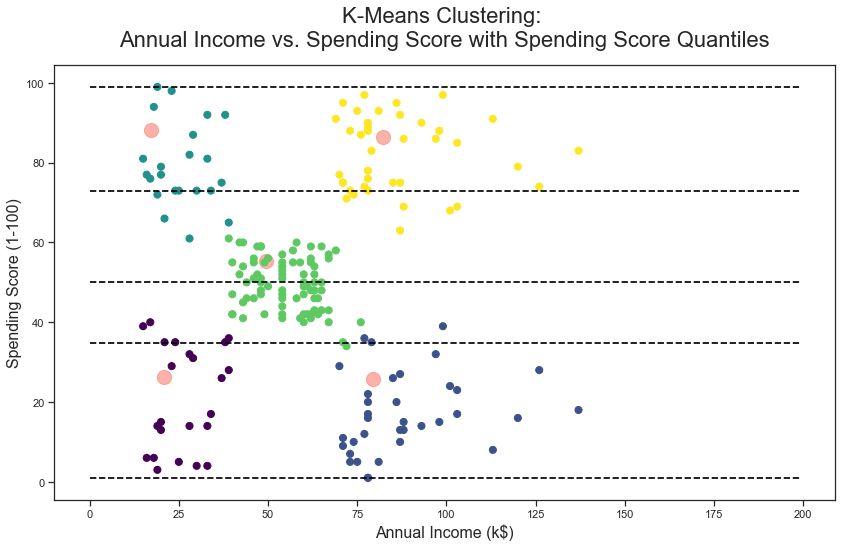

In [107]:
# We define ranges over which we want collect their respective customer IDs
ranges = list(data['Spending Score (1-100)'].quantile([0,0.25,0.50,0.75,1.0]))


plt.figure(figsize=(14,8))

fontsize = 22
# x=np.array(data['Annual Income (k$)'])
# y=np.array(data['Spending Score (1-100)'])
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='salmon', s=200, alpha=0.6)
# plt.scatter(x, y, c='c')
plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'], c=y_km, s=50, cmap='viridis')
for a in ranges:
    plt.plot(np.ones(len(data))*a, c='black', linewidth=1.7, linestyle='--')
plt.title("K-Means Clustering: \nAnnual Income vs. Spending Score with Spending Score Quantiles", 
          fontsize=fontsize, 
          y=1.03)
plt.xlabel("Annual Income (k$)", fontsize=16)
plt.ylabel("Spending Score (1-100)", fontsize=16)

plt.show()

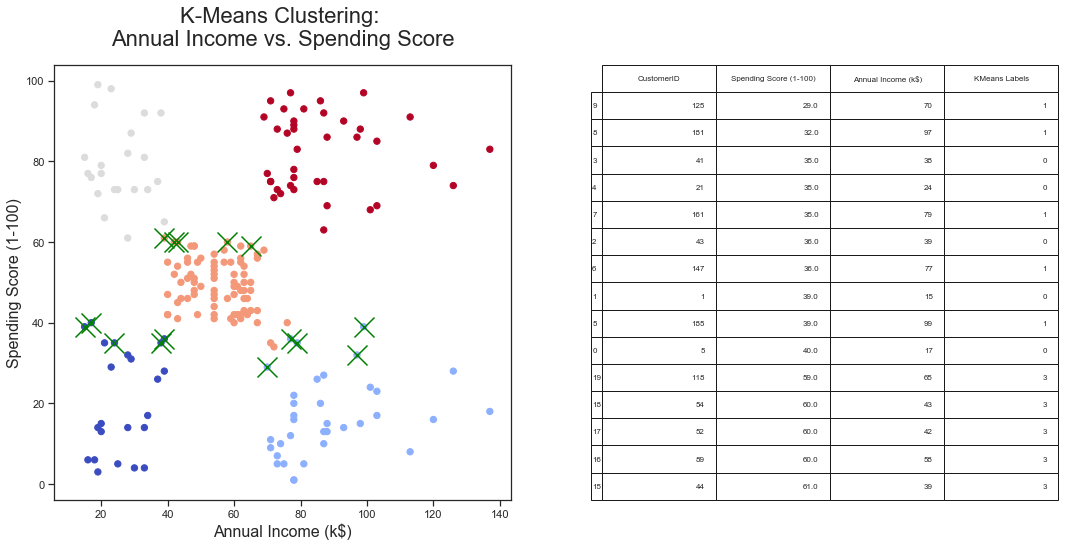

In [108]:
data['KMeans Labels'] = km.labels_

# We could simply take the customers with the Top 5 Spending Scores in each cluster
targets = []
scores = []
incomes = []
KMlabels = []
for a in range(5):
    targets.append(list(data.loc[data['KMeans Labels']==a].sort_values('Spending Score (1-100)', 
                                                                     ascending=False)['CustomerID'][:5]))
    scores.append(list(data.loc[data['KMeans Labels']==a].sort_values('Spending Score (1-100)', 
                                                                     ascending=False)['Spending Score (1-100)'][:5]))
    incomes.append(list(data.loc[data['KMeans Labels']==a].sort_values('Spending Score (1-100)', 
                                                                     ascending=False)['Annual Income (k$)'][:5]))
    KMlabels.append(list(data.loc[data['KMeans Labels']==a].sort_values('Spending Score (1-100)', 
                                                                     ascending=False)['KMeans Labels'][:5]))

import itertools

df = pd.DataFrame(dict({'CustomerID': list(itertools.chain.from_iterable(targets)), 
                        'Spending Score (1-100)': list(itertools.chain.from_iterable(scores)), 
                        'Annual Income (k$)': list(itertools.chain.from_iterable(incomes)), 
                        'KMeans Labels': list(itertools.chain.from_iterable(KMlabels))}))


# We only want the bottom 15 spending scores, assuming the top scores can't go higher
df = df.sort_values('Spending Score (1-100)')[:15]

df['Spending Score (1-100)'] = [float(a) for a in df['Spending Score (1-100)']]
df['CustomerID'] = [str(int(a)) for a in df['CustomerID']]




## Plotting
fig,ax = plt.subplots(1,2, figsize=(18,8))

fontsize = 22

ax[0].scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'], c=y_km, s=40, cmap='coolwarm')
ax[0].scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], c='green', s=400, marker='x')

ax[0].set_title("K-Means Clustering: \nAnnual Income vs. Spending Score", 
          fontsize=fontsize, 
          y=1.03)
ax[0].set_xlabel("Annual Income (k$)", fontsize=16)
ax[0].set_ylabel("Spending Score (1-100)", fontsize=16)

bbox=[0, 0, 1, 1]
# df.reset_index()
ax[1].table(cellText = df.values, rowLabels = df.index, bbox=bbox, colLabels=df.columns)
ax[1].axis('off')

plt.show()

# 6. The Target Customers

Below are the `CustomerIDs` of the target customers, marked with green X's on the scatterplot.

In [109]:
df.index = list(range(len(df)))
print("\n                 Target Customers:\n\n {}".format(df[['CustomerID', 
                                                               'Spending Score (1-100)', 
                                                               'KMeans Labels']]))


                 Target Customers:

    CustomerID  Spending Score (1-100)  KMeans Labels
0         125                    29.0              1
1         181                    32.0              1
2          41                    35.0              0
3          21                    35.0              0
4         161                    35.0              1
5          43                    36.0              0
6         147                    36.0              1
7           1                    39.0              0
8         185                    39.0              1
9           5                    40.0              0
10        118                    59.0              3
11         54                    60.0              3
12         52                    60.0              3
13         89                    60.0              3
14         44                    61.0              3


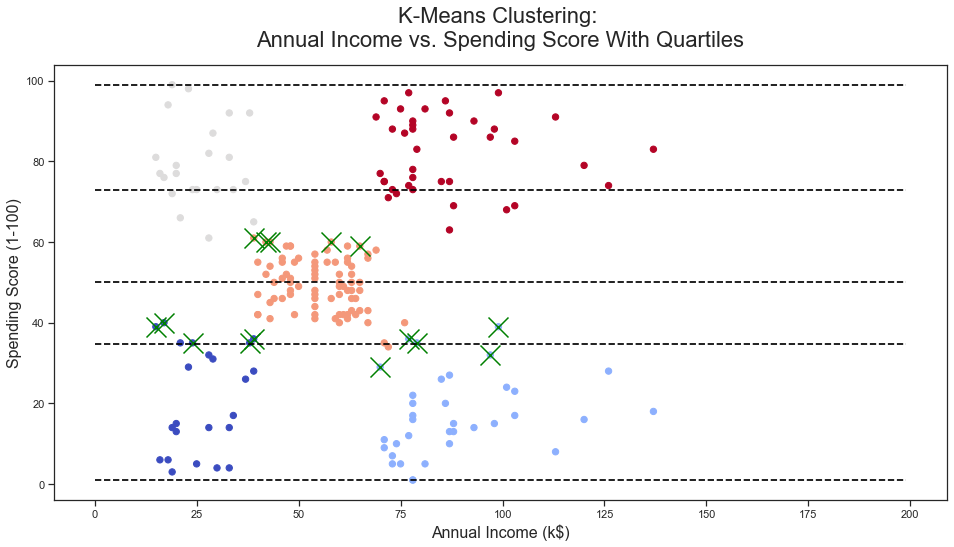

In [110]:
plt.figure(figsize=(16,8))

fontsize = 22

plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'], c=y_km, s=40, cmap='coolwarm')
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], c='green', s=400, marker='x')

plt.title("K-Means Clustering: \nAnnual Income vs. Spending Score With Quartiles", 
          fontsize=fontsize, 
          y=1.03)
plt.xlabel("Annual Income (k$)", fontsize=16)
plt.ylabel("Spending Score (1-100)", fontsize=16)
for a in ranges:
    plt.plot(np.ones(len(data))*a, c='black', linewidth=1.7, linestyle='--')
    
plt.show()